# Trabajo 2 - IA

Resumen aqui


In [2]:
!pip install imblearn

In [44]:
import kagglehub

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats
from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# custom transformers

from sklearn.base import BaseEstimator, TransformerMixin

# balanceo

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [4]:
path = kagglehub.dataset_download("therohithanand/used-car-price-prediction", path="used_car_price_dataset_extended.csv")

raw_df = pd.read_csv(path)
raw_df = raw_df.reset_index(drop=True)

### Limpiando el Dataframe

In [5]:
df = raw_df.copy()
df = df.drop(columns=['color', 'service_history'])
df.head()

,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,brand,transmission,accidents_reported,insurance_valid
0,2001,8.17,4000,Petrol,4,8587.64,Chevrolet,Manual,0,No
1,2014,17.59,1500,Petrol,4,5943.50,Honda,Manual,0,Yes
2,2023,18.09,2500,Diesel,5,9273.58,BMW,Automatic,1,Yes
3,2009,11.28,800,Petrol,1,6836.24,Hyundai,Manual,0,Yes
4,2005,12.23,1000,Petrol,2,4625.79,Nissan,Automatic,0,Yes


Se verifica si la variable respuesta es normal o no para elegir el método de balanceo de datos

<Axes: >

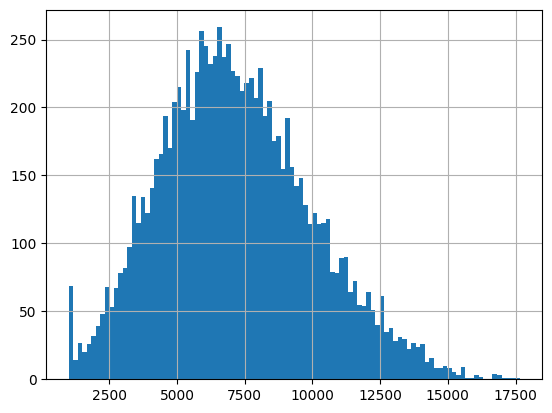

In [6]:
df['price_usd'].hist(bins=100)

In [7]:
# Ejecutar la prueba de Shapiro-Wilk
stat, p_value = shapiro(df['price_usd'])

# Mostrar resultados
print(f'Estadístico W: {stat}')
print(f'Valor p: {p_value}')

# Interpretación
if p_value > 0.05:
    print("Parece una distribución normal (no se rechaza H0)")
else:
    print("No parece una distribución normal (se rechaza H0)")

Estadístico W: 0.9907063127964498
Valor p: 5.045010001757705e-25
No parece una distribución normal (se rechaza H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


In [8]:
cols_priority = (df.corr(numeric_only=True).abs()['price_usd'].sort_values(ascending=False)).index[1:]
print(cols_priority.values)

['engine_cc' 'make_year' 'owner_count' 'mileage_kmpl' 'accidents_reported']


In [9]:
df['price_usd'].value_counts(bins=4).sort_index()

,count
"(983.351, 5161.908]",2478
"(5161.908, 9323.815]",5365
"(9323.815, 13485.722]",1960
"(13485.722, 17647.63]",197


<Axes: >

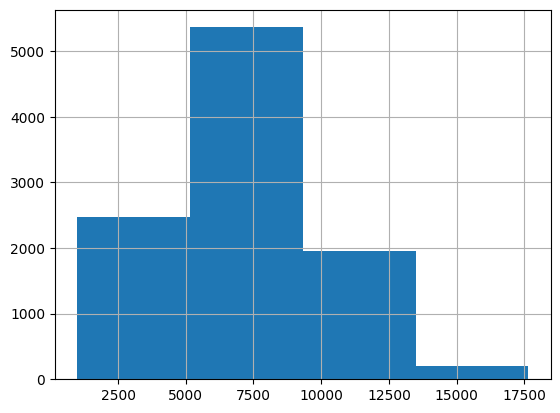

In [10]:
df['price_usd'].hist(bins=4)

In [11]:
#Mapea los categorias
#Convierte todo a categorias en vez de objetos
categorical_cols = df.select_dtypes(include='object').columns

df[categorical_cols] = df[categorical_cols].astype('category')

# convierte la variable objetivo a categorica
labels = ['Very Low', 'Low', 'Moderate', 'High']
df['price_usd'] = pd.cut(df['price_usd'], bins=4, labels=labels, include_lowest=True)

#Insertar variable dependiente de primero por comodidad
price_serie = df['price_usd']
df = df.drop(columns=['price_usd'])
df.insert(0, 'price_usd', price_serie)

df.head()


,price_usd,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,brand,transmission,accidents_reported,insurance_valid
0,Low,2001,8.17,4000,Petrol,4,Chevrolet,Manual,0,No
1,Low,2014,17.59,1500,Petrol,4,Honda,Manual,0,Yes
2,Low,2023,18.09,2500,Diesel,5,BMW,Automatic,1,Yes
3,Low,2009,11.28,800,Petrol,1,Hyundai,Manual,0,Yes
4,Very Low,2005,12.23,1000,Petrol,2,Nissan,Automatic,0,Yes


<Axes: xlabel='price_usd', ylabel='count'>

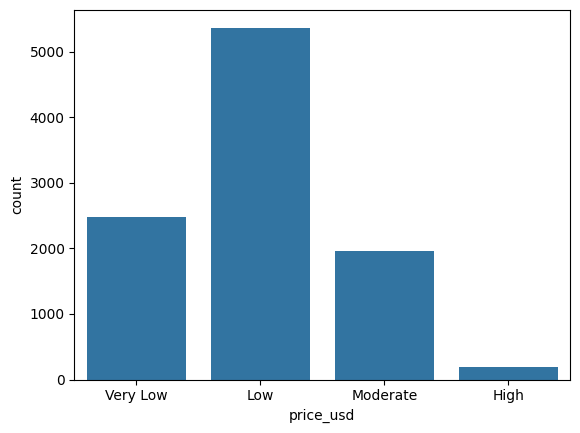

In [12]:
sns.countplot(x='price_usd', data=df, order=labels)

## Pipeline

In [13]:
class OutliersHandler(BaseEstimator, TransformerMixin):
    """
    Transformer personalizado para el manejo de outliers en conjuntos de datos numéricos.

    Este transformador permite dos modos de operación:
    - Eliminación de outliers usando el criterio del rango intercuartílico (IQR).
    - Generación de outliers sintéticos para asegurar que representen el 5% del total del dataset.

    Parámetros
    ----------
    make_outliers : bool, default=False
        Si es True, se generarán outliers sintéticos en lugar de eliminarlos.
    """
    def __init__(self, make_outliers = False):
        self.column_name = ""
        self.make_outliers = make_outliers

    def fit(self, X, y=None):
        return self  # The fit method typically does nothing for transformers

    def transform(self, X):
        # Your transformation logic goes here
        X_transformed = X.copy()  # Copy the input DataFrame to avoid modifying the original
        X_transformed = self._make_outliers(X_transformed) if self.make_outliers else self._delete_outliers(X_transformed)

        return X_transformed

    # Elimina las filas, donde uno de los valores numericos este fuera de los intervalos
    def _delete_outliers(self, df: pd.DataFrame):
        float_cols = df.select_dtypes('float64').columns

        for col in float_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)

            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        return df

    def _make_outliers(self, df: pd.DataFrame, random_state: int = 42) -> pd.DataFrame:
        """
        A partir del df original, detecta sus outliers y genera (replicándolos
        y añadiendo un pequeño ruido) tantas tuplas como hagan falta para que
        los outliers representen el 5% del total.

        Parámetros:
        - df: DataFrame de entrada.
        - random_state: semilla para la aleatoriedad.

        Retorna:
        - DataFrame con 5% outliers o sin outliers.
        """
        float_cols = df.select_dtypes(include='float64').columns

        outlier_mask = pd.Series(False, index=df.index)
        for col in float_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outlier_mask |= (df[col] < lower) | (df[col] > upper)

        outliers = df[outlier_mask]
        non_outliers = df[~outlier_mask]

        total_orig = len(df)
        n_outliers = len(outliers)
        target_outliers = int(np.floor(0.05 * total_orig))

        # Si hay menos outliers que el 5%, generamos más
        needed = target_outliers - n_outliers
        synth = outliers.sample(n=needed, replace=True, random_state=random_state)
        # Clonamos los outliers existentes pero les añadimos  ruido
        for col in float_cols:
            sigma = df[col].std() * 0.01
            synth[col] = synth[col] + np.random.RandomState(random_state).normal(0, sigma, size=needed)
        result = pd.concat([df, synth], ignore_index=True)

        return result


In [14]:
def outliers_maker(data, make_outliers = False):
    outliers = OutliersHandler(make_outliers=make_outliers)
    return outliers.fit_transform(data)

def scaler(X_train, X_test, columns):
    # fit_transform en X_train y transform en X_test
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    std_scaler = StandardScaler()

    X_train_scaled[columns] = std_scaler.fit_transform(X_train[columns])
    X_test_scaled[columns] = std_scaler.transform(X_test[columns])

    return X_train_scaled, X_test_scaled

def X_encoder(X_train : pd.DataFrame, X_test : pd.DataFrame, columns : str):
    # para X_train y X_test (despues de escalar)
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    oh_enc = OneHotEncoder(sparse_output=False)

    # aplicar one_hot
    X_train_cat = oh_enc.fit_transform(X_train[columns])
    X_test_cat = oh_enc.transform(X_test[columns])

    # Get feature names for the encoded columns
    encoded_cat_features = oh_enc.get_feature_names_out(columns)

    # Create DataFrames from encoded arrays
    X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=encoded_cat_features)
    X_test_cat_df = pd.DataFrame(X_test_cat, index=X_test.index, columns=encoded_cat_features)

    # juntar columnas con one_hot con el resto del dataframe
    X_train_encoded = X_train_encoded.drop(columns = columns)
    X_test_encoded = X_test_encoded.drop(columns = columns)
    X_train_encoded = X_train_encoded.join(X_train_cat_df)
    X_test_encoded = X_test_encoded.join(X_test_cat_df)

    return X_train_encoded, X_test_encoded

def y_encoder(y_train, y_test):
    ord_enc = OrdinalEncoder(categories=[['Very Low', 'Low', 'Moderate', 'High']])

    y_train_encoded = pd.DataFrame(y_train)
    y_test_encoded = pd.DataFrame(y_test)

    # aplicar ordinal_enc
    y_train_encoded = ord_enc.fit_transform(y_train_encoded)
    y_test_encoded = ord_enc.transform(y_test_encoded)

    print({i: cat for i, cat in enumerate(list(ord_enc.categories_[0]))})

    return y_train_encoded, y_test_encoded

def balancer(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)


In [21]:
def outliers_maker(data, make_outliers = False):
    outliers = OutliersHandler(make_outliers=make_outliers)
    return outliers.fit_transform(data)

def scaler(X_train, X_test, columns):
    # fit_transform en X_train y transform en X_test
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    std_scaler = StandardScaler()

    X_train_scaled[columns] = std_scaler.fit_transform(X_train[columns])
    X_test_scaled[columns] = std_scaler.transform(X_test[columns])

    return X_train_scaled, X_test_scaled

def X_encoder(X_train : pd.DataFrame, X_test : pd.DataFrame, columns : str):
    # para X_train y X_test (despues de escalar)
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    oh_enc = OneHotEncoder(sparse_output=False)

    # aplicar one_hot
    X_train_cat = oh_enc.fit_transform(X_train[columns])
    X_test_cat = oh_enc.transform(X_test[columns])

    # Get feature names for the encoded columns
    encoded_cat_features = oh_enc.get_feature_names_out(columns)

    # Create DataFrames from encoded arrays
    X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=encoded_cat_features)
    X_test_cat_df = pd.DataFrame(X_test_cat, index=X_test.index, columns=encoded_cat_features)

    # juntar columnas con one_hot con el resto del dataframe
    X_train_encoded = X_train_encoded.drop(columns = columns)
    X_test_encoded = X_test_encoded.drop(columns = columns)
    X_train_encoded = X_train_encoded.join(X_train_cat_df)
    X_test_encoded = X_test_encoded.join(X_test_cat_df)

    return X_train_encoded, X_test_encoded

def y_encoder(y):
    ord_enc = OrdinalEncoder(categories=[['Very Low', 'Low', 'Moderate', 'High']])

    y_encoded = pd.DataFrame(y)

    # aplicar ordinal_enc
    y_encoded = ord_enc.fit_transform(y_encoded)

    print({i: cat for i, cat in enumerate(list(ord_enc.categories_[0]))})

    return y_encoded

def balancer(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)


In [39]:
def pipeline_maker(dataframe : pd.DataFrame, model : str, y_label : str = 'price_usd', make_outliers = False, balance = False, scale = False):
    data = dataframe.copy()

    # hacer outliers
    if make_outliers == True:
        data = outliers_maker(data, make_outliers=True)
    else:
        data = outliers_maker(data, make_outliers=False)

    # Encode target variable
    y = y_encoder(data[y_label])
    X = data.drop(columns=[y_label])

    # lista donde se almacenarán los steps a usar
    steps = []

    cat_features = X.select_dtypes(include='category').columns
    num_features = X.select_dtypes(include='number').columns

    # escalado de datos
    if scale:
        col_transformer = ColumnTransformer([
            ('std_scaler', StandardScaler(), num_features),
            ('one_hot', OneHotEncoder(), cat_features)
        ])
    else: # en caso de no escalar
        col_transformer = ColumnTransformer([
            ('one_hot', OneHotEncoder(), cat_features)
        ])
    steps.append(('preprocessor', col_transformer))

    # balanceo con smote
    if balance:
        steps.append(
            ('smote', SMOTE(random_state=42))
            )

    # seleccion de modelo
    if model == 'svm':
        steps.append(
            ('SVC', SVC(random_state=42))
        )
    elif model == 'knn':
        steps.append(
            ('knn', KNeighborsClassifier())
        )
    elif model == 'tree':
        steps.append(
            ('decision_tree', DecisionTreeClassifier(random_state=42))
        )
    elif model == 'nn':
        raise NotImplementedError("modelo no implementado")
        steps.append(
            ('neural_network', None)
        )
    else:
        raise ValueError("Ingrese uno de los siguientes: 'svm', 'knn', 'tree', 'nn'")


    pipeline = imbPipeline(steps)

    return X, y, pipeline

In [41]:
X, y, pipeline = pipeline_maker(df, 'knn', make_outliers=True, balance=True, scale=True)
# pipeline.fit(X,y)

{0: 'Very Low', 1: 'Low', 2: 'Moderate', 3: 'High'}


## KNN

In [46]:
np.logspace(-3, 2, 10)

array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_dist = {
    'knn__n_neighbors': list(range(2,20))        # Vecinos para KNN
}

'''
# Espacio de búsqueda
param_dist = {
    'clf__C': np.logspace(-3, 2, 10),
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__gamma': ['scale', 'auto']
}
'''
grid = RandomizedSearchCV(pipeline,
                          param_distributions=param_dist,
                          n_iter=10,
                          cv=10,
                          scoring=['accuracy','f1_macro'],
                          refit='f1_macro',
                          random_state=42)

grid.fit(X_train,y_train)

print("Mejores parámetros encontrados:", grid.best_params_)
print(f"Mejor score CV: {grid.best_score_:.3f}")

y_pred = grid.predict(X_test)
print("\nReporte en test set:\n", classification_report(y_test, y_pred))


Mejores parámetros encontrados: {'knn__n_neighbors': 10}
Mejor score CV: 0.622

Reporte en test set:
               precision    recall  f1-score   support

         0.0       0.61      0.87      0.71       625
         1.0       0.83      0.62      0.71      1403
         2.0       0.65      0.69      0.67       531
         3.0       0.37      0.70      0.48        57

    accuracy                           0.70      2616
   macro avg       0.62      0.72      0.65      2616
weighted avg       0.73      0.70      0.70      2616



In [ ]:
X, y, pipeline = pipeline_maker(df, 'svm', make_outliers=True, balance=True, scale=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
'''
param_dist = {
    'knn__n_neighbors': list(range(2,20))        # Vecinos para KNN
}

'''
# Espacio de búsqueda
param_dist = {
    'SVC__C': np.logspace(-3, 2, 10),
    'SVC__kernel': ['linear', 'rbf', 'poly'],
    'SVC__gamma': ['scale', 'auto']
}

grid = RandomizedSearchCV(pipeline,
                          param_distributions=param_dist,
                          n_iter=10,
                          cv=10,
                          scoring=['accuracy','f1_macro'],
                          refit='f1_macro',
                          verbose=3,
                          random_state=42)

grid.fit(X_train,y_train)

print("Mejores parámetros encontrados:", grid.best_params_)
print(f"Mejor score CV: {grid.best_score_:.3f}")

y_pred = grid.predict(X_test)
print("\nReporte en test set:\n", classification_report(y_test, y_pred))


{0: 'Very Low', 1: 'Low', 2: 'Moderate', 3: 'High'}
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear; accuracy: (test=0.741) f1_macro: (test=0.670) total time=  13.3s
[CV 2/10] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear; accuracy: (test=0.750) f1_macro: (test=0.693) total time=   8.0s
[CV 3/10] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear; accuracy: (test=0.741) f1_macro: (test=0.685) total time=   9.2s
[CV 4/10] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear; accuracy: (test=0.735) f1_macro: (test=0.663) total time=   9.3s
[CV 5/10] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear; accuracy: (test=0.728) f1_macro: (test=0.679) total time=   8.0s
[CV 6/10] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear; accuracy: (test=0.725) f1_macro: (test=0.658) total time=   9.3s
[CV 7/10] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear; accuracy: (test=0.765) f1_macro: 